# Theano, Lasagne
and why they matter


### got no lasagne?
Install the __bleeding edge__ version from here: http://lasagne.readthedocs.org/en/latest/user/installation.html

# Warming up
* Implement a function that computes the sum of squares of numbers from 0 to N
* Use numpy or python
* An array of numbers 0 to N - numpy.arange(N)

In [1]:
import numpy as np
def sum_squares(N):
    return N * (N - 1) * (2 * N - 1) // 6

In [2]:
%%time
sum_squares(10**8)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


333333328333333350000000

# theano teaser

Doing the very same thing

In [3]:
import theano
import theano.tensor as T

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)


In [4]:


#I gonna be function parameter
N = T.scalar("a dimension",dtype='int32')


#i am a recipe on how to produce sum of squares of arange of N given N
result = (T.arange(N)**2).sum()

#Compiling the recipe of computing "result" given N
sum_function = theano.function(inputs = [N],outputs=result)

In [5]:
%%time
sum_function(10**8)

CPU times: user 276 ms, sys: 176 ms, total: 452 ms
Wall time: 452 ms


array(662921401752298880)

# How does it work?
* 1 You define inputs f your future function;
* 2 You write a recipe for some transformation of inputs;
* 3 You compile it;
* You have just got a function!
* The gobbledegooky version: you define a function as symbolic computation graph.


* There are two main kinds of entities: "Inputs" and "Transformations"
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be integers, floats of booleans (uint8) of various size.


* An input is a placeholder for function parameters.
 * N from example above


* Transformations are the recipes for computing something given inputs and transformation
 * (T.arange(N)^2).sum() are 3 sequential transformations of N
 * Doubles all functions of numpy vector syntax
 * You can almost always go with replacing "np.function" with "T.function" aka "theano.tensor.function"
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * and so on.
   * builtin operations also work that way
   * np.arange(10).mean() -> T.arange(10).mean()
   * Once upon a blue moon the functions have different names or locations (e.g. T.extra_ops)
     * Ask us or google it
 
 
Still confused? We gonna fix that.

In [6]:
#Inputs
example_input_integer = T.scalar("scalar input",dtype='float32')

example_input_tensor = T.tensor4("four dimensional tensor input") #dtype = theano.config.floatX by default
#не бойся, тензор нам не пригодится

input_vector = T.vector("my vector", dtype='int32') # vector of integers


In [7]:
#Transformations

#transofrmation: elementwise multiplication
double_the_vector = input_vector*2

#elementwise cosine
elementwise_cosine = T.cos(input_vector)

#difference between squared vector and vector itself
vector_squares = input_vector**2 - input_vector


In [8]:
#Practice time:
#create two vectors of size float32
my_vector = T.vector(name='first vector', dtype='float32')
my_vector2 = T.vector(name='second vector', dtype='float32')

In [9]:
#Write a transformation(recipe):
#(vec1)*(vec2) / (sin(vec1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + 1)

In [10]:
print( my_transformation)
#it's okay it aint a number

Elemwise{true_div,no_inplace}.0


In [11]:
#What's inside the transformation
theano.printing.debugprint(my_transformation)

Elemwise{true_div,no_inplace} [id A] ''   
 |Elemwise{mul,no_inplace} [id B] ''   
 | |first vector [id C]
 | |second vector [id D]
 |Elemwise{add,no_inplace} [id E] ''   
   |Elemwise{sin,no_inplace} [id F] ''   
   | |first vector [id C]
   |InplaceDimShuffle{x} [id G] ''   
     |TensorConstant{1} [id H]


# Compiling
* So far we were using "symbolic" variables and transformations
 * Defining the recipe for computation, but not computing anything
* To use the recipe, one should compile it

In [12]:
inputs = [my_vector, my_vector2]
outputs = [my_transformation]

# The next lines compile a function that takes two vectors and computes your transformation
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #automatic type casting for input parameters (e.g. float64 -> float32)
 )

In [13]:
#using function with, lists:
print ("using python lists:")
print (my_function([1,2,3],[4,5,6]))
print

#Or using numpy arrays:
#btw, that 'float' dtype is casted to secong parameter dtype which is float32
print ("using numpy arrays:")
print (my_function(np.arange(10),
                  np.linspace(5,6,10,dtype='float')))


using python lists:
[array([  2.1721766 ,   5.23752832,  15.77397728], dtype=float32)]
using numpy arrays:
[array([   0.        ,    2.77555895,    5.47030783,   14.02131271,
         89.5477066 ,  676.25805664,   47.183918  ,   24.4084301 ,
         23.68156242,   38.24041748], dtype=float32)]


# Debugging
* Compilation can take a while for big functions
* To avoid waiting, one can evaluate transformations without compiling
* Without compilation, the code runs slower, so consider reducing input size


In [14]:
#a dictionary of inputs
my_function_inputs = {
    my_vector:[1,2,3],
    my_vector2:[4,5,6]
}

# evaluate my_transformation
# has to match with compiled function output
print (my_transformation.eval(my_function_inputs))


# can compute transformations on the fly
print ("add 2 vectors", (my_vector + my_vector2).eval(my_function_inputs))

#!WARNING! if your transformation only depends on some inputs,
#do not provide the rest of them
print ("vector's shape:", my_vector.shape.eval({
        my_vector:[1,2,3]
    }))


[  2.1721766    5.23752832  15.77397728]
add 2 vectors [ 5.  7.  9.]
vector's shape: [3]


* When debugging, it's usually a good idea to reduce the scale of your computation. E.g. if you train on batches of 128 objects, debug on 2-3.
* If it's imperative that you run a large batch of data, consider compiling with mode='debug' instead

# Your turn: Mean Squared Error (2 pts)

In [15]:
# Quest #1 - implement a function that computes a mean squared error of two input vectors
# Your function has to take 2 vectors and return a single number

prediction = T.vector(dtype='float32')
target = T.vector(dtype='float32')

compute_mse = theano.function([prediction, target], outputs=T.mean((prediction - target) ** 2), 
                              allow_input_downcast=True)

In [16]:
# Tests
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print ('Wrong result:')
                print ('mse(%s,%s)'%(el,el_2))
                print ("should be: %f, but your function returned %f"%(true_mse,my_mse))
                raise ValueError("Что-то не так")

print ("All tests passed")
            
    

All tests passed


# Shared variables

* The inputs and transformations only exist when function is called

* Shared variables always stay in memory like global variables
 * Shared variables can be included into a symbolic graph
 * They can be set and evaluated using special methods
   * but they can't change value arbitrarily during symbolic graph computation
   * we'll cover that later;
 
 
* Hint: such variables are a perfect place to store network parameters
 * e.g. weights or some metadata

In [17]:
#creating shared variable
shared_vector_1 = theano.shared(np.ones(10,dtype='float64'))

In [18]:

#evaluating shared variable (outside symbolicd graph)
print ("initial value",shared_vector_1.get_value())

# within symbolic graph you use them just as any other inout or transformation, not "get value" needed

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [19]:
#setting new value
shared_vector_1.set_value( np.arange(5) )

#getting that new value
print ("new value", shared_vector_1.get_value())

#Note that the vector changed shape
#This is entirely allowed... unless your graph is hard-wired to work with some fixed shape

new value [ 0.  1.  2.  3.  4.]


# Your turn

In [20]:
# Write a recipe (transformation) that computes an elementwise transformation of shared_vector and input_scalar
#Compile as a function of input_scalar

input_scalar = T.scalar('coefficient',dtype='float32')

scalar_times_shared = input_scalar * shared_vector_1

shared_times_n = theano.function([input_scalar], scalar_times_shared, allow_input_downcast=True)

In [21]:
print ("shared:", shared_vector_1.get_value())

print ("shared_times_n(5)",shared_times_n(5))

print ("shared_times_n(-0.5)",shared_times_n(-0.5))


shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [  0.   5.  10.  15.  20.]
shared_times_n(-0.5) [-0.  -0.5 -1.  -1.5 -2. ]


In [22]:
#Changing value of vector 1 (output should change)
shared_vector_1.set_value([-1,0,1])
print ("shared:", shared_vector_1.get_value())

print ("shared_times_n(5)",shared_times_n(5))

print ("shared_times_n(-0.5)",shared_times_n(-0.5))


shared: [-1.  0.  1.]
shared_times_n(5) [-5.  0.  5.]
shared_times_n(-0.5) [ 0.5 -0.  -0.5]


# T.grad - why theano matters
* Theano can compute derivatives and gradients automatically
* Derivatives are computed symbolically, not numerically

Limitations:
* You can only compute a gradient of a __scalar__ transformation over one or several scalar or vector (or tensor) transformations or inputs.
* A transformation has to have float32 or float64 dtype throughout the whole computation graph
 * derivative over an integer has no mathematical sense


In [23]:
my_scalar = T.scalar(name='input',dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#a derivative of v_squared by my_vector
derivative = T.grad(scalar_squared,my_scalar)

fun = theano.function([my_scalar],scalar_squared)
grad = theano.function([my_scalar],derivative) 

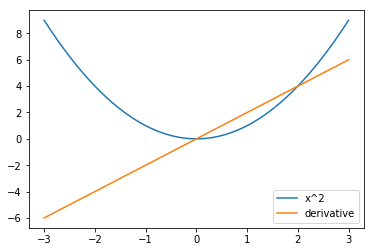

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline


x = np.linspace(-3,3)
x_squared = list(map(fun,x))
x_squared_der = list(map(grad,x))

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# Why that rocks

In [25]:

my_vector = T.vector('float64')

#Compute the gradient of the next weird function over my_scalar and my_vector
#warning! Trying to understand the meaning of that function may result in permanent brain damage

weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2


der_by_scalar = T.grad(weird_psychotic_function, [my_scalar])
der_by_vector = T.grad(weird_psychotic_function, [my_vector])


compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)


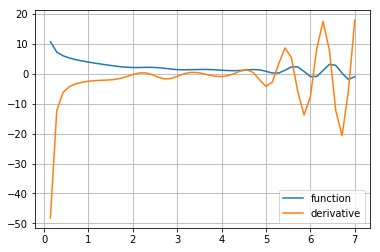

In [26]:
#Plotting your derivative
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


# Almost done - Updates

* updates are a way of changing shared variables at after function call.

* technically it's a dictionary {shared_variable : a recipe for new value} which is has to be provided when function is compiled

That's how it works:

In [27]:
# Multiply shared vector by a number and save the product back into shared vector

inputs = [input_scalar]
outputs = [scalar_times_shared] #return vector times scalar

my_updates = {
    shared_vector_1:scalar_times_shared #and write this same result bach into shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [28]:
shared_vector_1.set_value(np.arange(5))

#initial shared_vector_1
print ("initial shared value:" ,shared_vector_1.get_value())

# evaluating the function (shared_vector_1 will be changed)
print ("compute_and_save(2) returns",compute_and_save(2))

#evaluate new shared_vector_1
print ("new shared value:" ,shared_vector_1.get_value())



initial shared value: [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 0.,  2.,  4.,  6.,  8.])]
new shared value: [ 0.  2.  4.  6.  8.]


# Logistic regression example (4 pts)

Implement the regular logistic regression training algorithm

Tips:
* Weights fit in as a shared variable
* X and y are potential inputs
* Compile 2 functions:
 * train_function(X,y) - returns error and computes weights' new values __(through updates)__
 * predict_fun(X) - just computes probabilities ("y") given data
 
 
We shall train on a two-class MNIST dataset
* please note that target y are {0,1} and not {-1,1} as in some formulae

In [29]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X,y = mnist.data, mnist.target


print ("y [shape - %s]:"%(str(y.shape)),y[:10])

print ("X [shape - %s]:"%(str(X.shape)))
print (X[:3])
print (y[:10])

y [shape - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [shape - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [30]:
# inputs and shareds
shared_weights = theano.shared(np.random.randn(X.shape[1]), allow_downcast=True, name="w")
shared_b = theano.shared(0., name="b", allow_downcast=True)
input_X = T.matrix(dtype='float32', name="x")
input_y = T.vector(dtype='float32', name="y")

In [31]:
predicted_y = 1. / (T.exp(-T.dot(input_X, shared_weights) - shared_b) + 1)


loss = -T.mean(input_y * T.log(predicted_y) +\
            (1 - input_y) * T.log(1 - predicted_y)) +\
            1e-2 * (shared_weights ** 2).sum()


grad_w, grad_b = T.grad(loss, [shared_weights, shared_b])


updates = [
    (shared_weights, shared_weights - 0.1 * grad_w),
    (shared_b, shared_b - 0.1 * grad_b)
]

In [32]:
train_function = theano.function([input_X, input_y], loss, updates=updates, allow_input_downcast=True)

predict_function = theano.function([input_X], predicted_y > 0.5, allow_input_downcast=True)

In [33]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

/home/ubuntu/env/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loss at iter 0:nan
train auc: 0.869894598155
test auc: 0.877470355731
loss at iter 1:nan
train auc: 0.904644268775
test auc: 0.909584980237
loss at iter 2:nan
train auc: 0.928853754941
test auc: 0.955533596838
loss at iter 3:nan
train auc: 0.948781291173
test auc: 0.965909090909
loss at iter 4:nan
train auc: 0.955368906456
test auc: 0.966403162055
resulting weights:


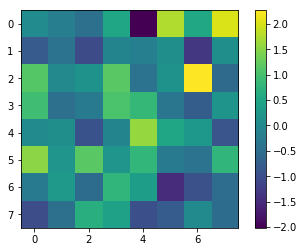

In [34]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train,y_train)
    print ("loss at iter %i:%.4f"%(i,loss_i))
    print ("train auc:",roc_auc_score(y_train,predict_function(X_train)))
    print ("test auc:",roc_auc_score(y_test,predict_function(X_test)))

    
print ("resulting weights:")
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

In [3]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


In [4]:
import lasagne

input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Defining network architecture

In [5]:
#Input layer (auxilary)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)
dense_1 = lasagne.layers.DenseLayer(input_layer,num_units=50,
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   name = "hidden_dense_layer")

#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
dense_output = lasagne.layers.DenseLayer(dense_1,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')


In [6]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(dense_output)

In [39]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(dense_output)
print (all_weights)

[hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [40]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.01)

In [41]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [14]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# X - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# y - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

#What do need to implement
# 1) Shuffle data
# - Gotta shuffle X and y the same way not to break the correspondence between X_i and y_i
# 3) Split data into minibatches of batch_size
# - If data size is not a multiple of batch_size, make one last batch smaller.
# 4) return a list (or an iterator) of pairs
# - (подгруппа картинок, ответы из y на эту подгруппу)
def iterate_minibatches(X, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield X[excerpt], y[excerpt]


# Training loop

In [43]:
import time

num_epochs = 100 #amount of passes through the data

batch_size = 50 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 1.629s
  training loss (in-iteration):		1.842446
  train accuracy:		57.53 %
  validation accuracy:		73.99 %
Epoch 2 of 100 took 1.619s
  training loss (in-iteration):		1.196802
  train accuracy:		75.92 %
  validation accuracy:		82.12 %
Epoch 3 of 100 took 1.623s
  training loss (in-iteration):		0.876681
  train accuracy:		81.33 %
  validation accuracy:		84.96 %
Epoch 4 of 100 took 1.621s
  training loss (in-iteration):		0.711249
  train accuracy:		84.12 %
  validation accuracy:		87.03 %
Epoch 5 of 100 took 1.621s
  training loss (in-iteration):		0.612473
  train accuracy:		85.83 %
  validation accuracy:		88.18 %
Epoch 6 of 100 took 1.620s
  training loss (in-iteration):		0.547055
  train accuracy:		87.04 %
  validation accuracy:		88.90 %
Epoch 7 of 100 took 1.625s
  training loss (in-iteration):		0.500743
  train accuracy:		87.78 %
  validation accuracy:		89.48 %
Epoch 8 of 100 took 1.616s
  training loss (in-iteration):		0.466424
  train accuracy:		88.37 %
  valida

In [44]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

Final results:
  test accuracy:		94.93 %
We need more magic!


# A better network ( 4+ pts )


* The quest is to create a network that gets at least 99% at test set
 * In case you tried several architectures and have a __detailed__ report - 97.5% "is fine too". 
 * __+1 bonus point__ each 0.2% past 99%
 * More points for creative approach
 
__ There is a mini-report at the end that you will have to fill in. We recommend to read it first and fill in while you are iterating. __
 

## Tips on what can be done:



 * Network size
   * MOAR neurons, 
   * MOAR layers, 
   * Convolutions are almost imperative
   * Пх'нглуи мглв'нафх Ктулху Р'льех вгах'нагл фхтагн! 
   
   
   
 * Regularize to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
   * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   
   
   
 * Better optimization - rmsprop, nesterov_momentum, adadelta, adagrad and so on.
   * Converge faster and sometimes reach better optima
   * It might make sense to tweak learning rate, other learning parameters, batch size and number of epochs
   
   
   
 * Dropout - to prevent overfitting
   * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`
   
   
   
 * Convolution layers
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                       num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
 
 * Plenty other layers and architectures
   * http://lasagne.readthedocs.org/en/latest/modules/layers.html
   * batch normalization, pooling, etc
   
   
 * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way

In [1]:
import numpy as np
from IPython import display
import theano
from theano import tensor as T
import lasagne
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5105)


In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print (X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


In [3]:
input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

In [30]:
#Input layer (auxilary)
#Input layer (auxilary)
nn = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

nn = lasagne.layers.Conv2DLayer(nn, 128, (5,5), nonlinearity=lasagne.nonlinearities.rectify)
nn = lasagne.layers.MaxPool2DLayer(nn, (2,2))
nn = lasagne.layers.Conv2DLayer(nn, 64, (3,3), nonlinearity=lasagne.nonlinearities.rectify)
nn = lasagne.layers.MaxPool2DLayer(nn, (2,2))

nn = lasagne.layers.DropoutLayer(nn)

nn = lasagne.layers.DenseLayer(nn, num_units=128, nonlinearity = lasagne.nonlinearities.rectify)

dense_output = lasagne.layers.DenseLayer(nn,num_units = 10, nonlinearity = lasagne.nonlinearities.softmax)

In [31]:
# Network predictions (theano-transformation)
y_predicted_train = lasagne.layers.get_output(dense_output)
y_predicted_test = lasagne.layers.get_output(dense_output, deterministic=True)

In [32]:
all_weights = lasagne.layers.get_all_params(dense_output)

In [33]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted_train,target_y).mean()
#       + 0.001 * lasagne.regularization.regularize_network_params(dense_output, lasagne.regularization.l2)

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted_test,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [34]:
#A function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#A function that just computes accuracy given X and y
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [35]:
def iterate_minibatches(X, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield X[excerpt], y[excerpt]

In [36]:
num_epochs = 50

batch_size = 500

train_loss = []
train_accuracy = []
val_accuracy = []

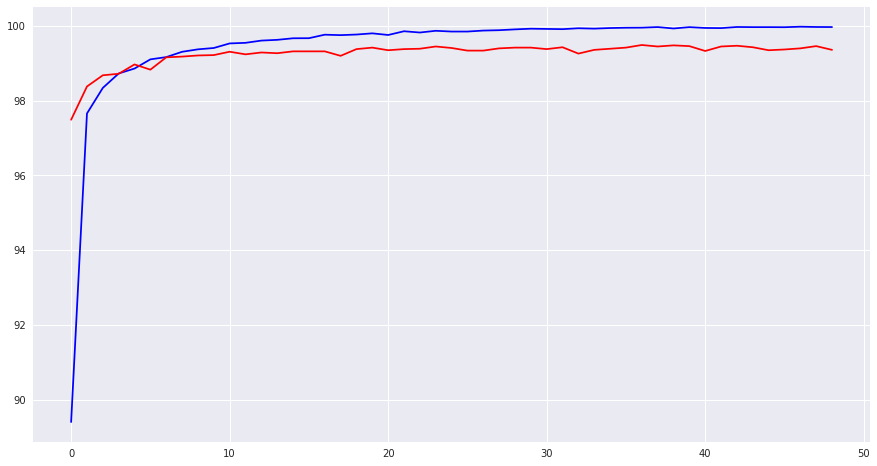

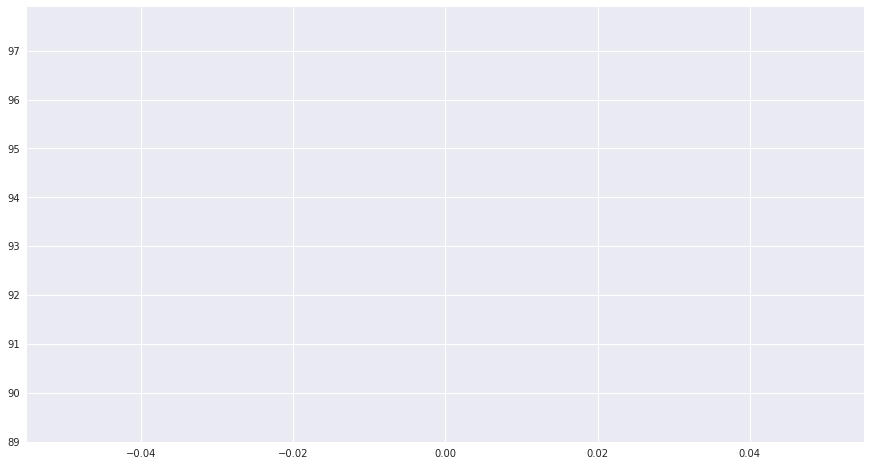

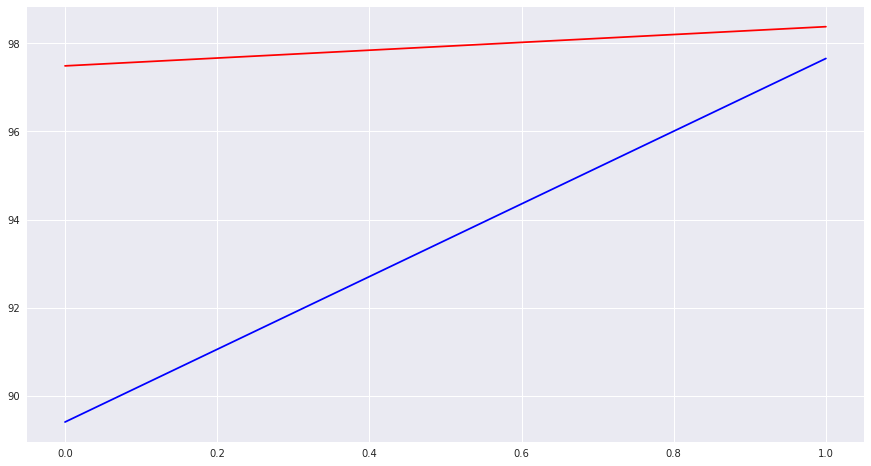

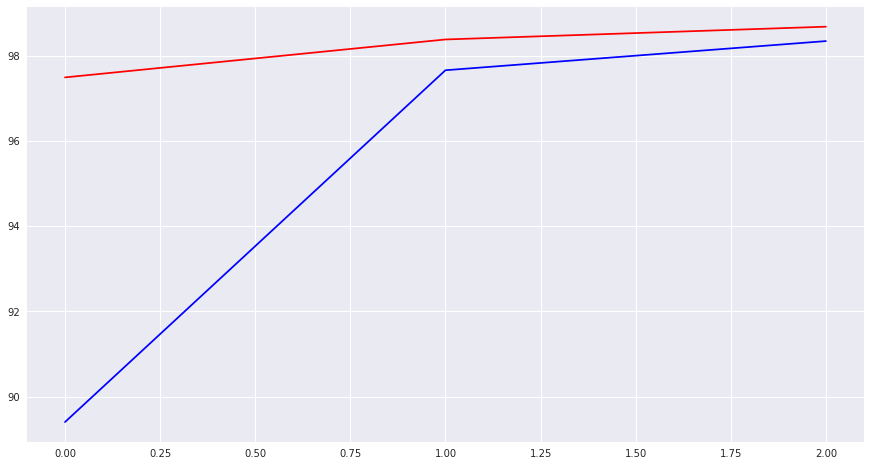

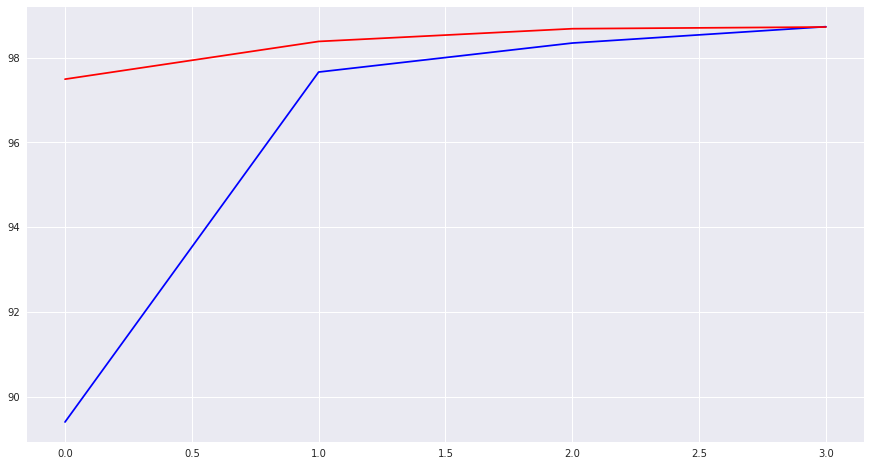

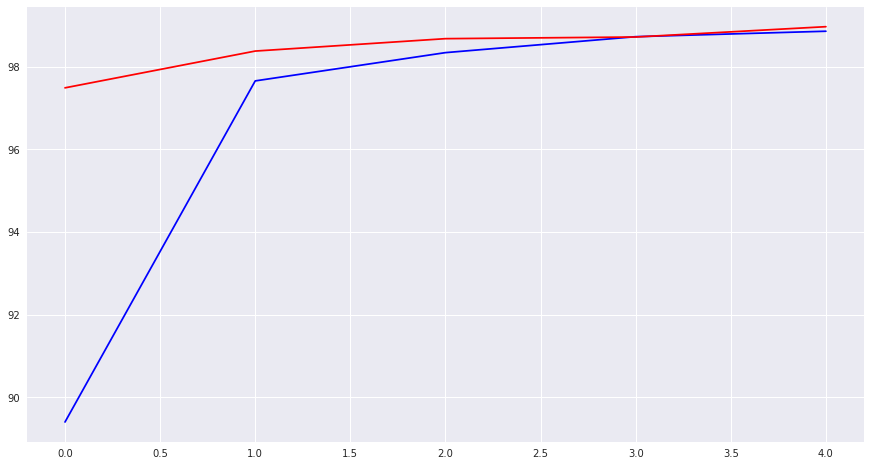

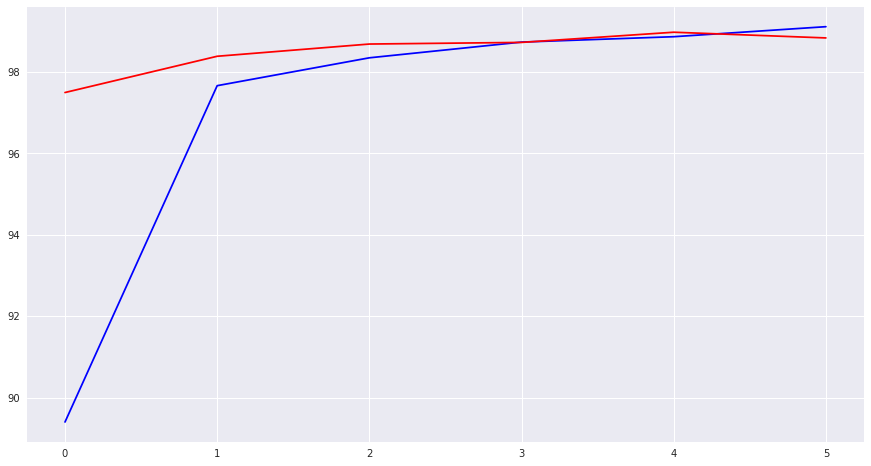

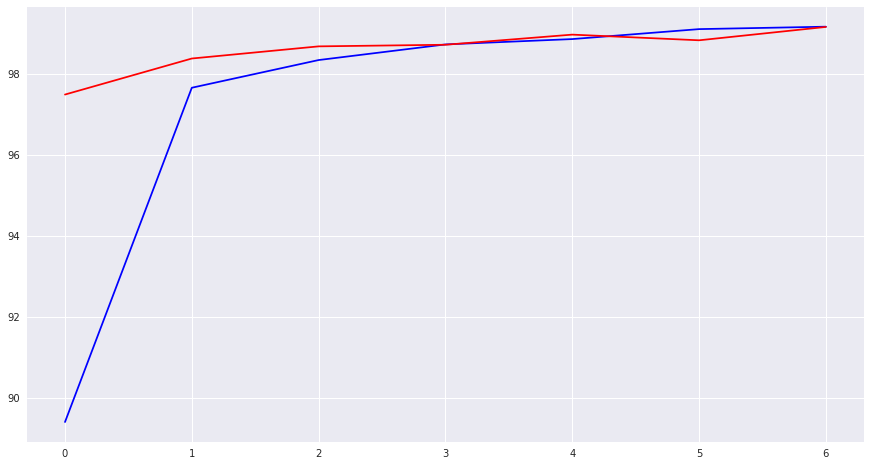

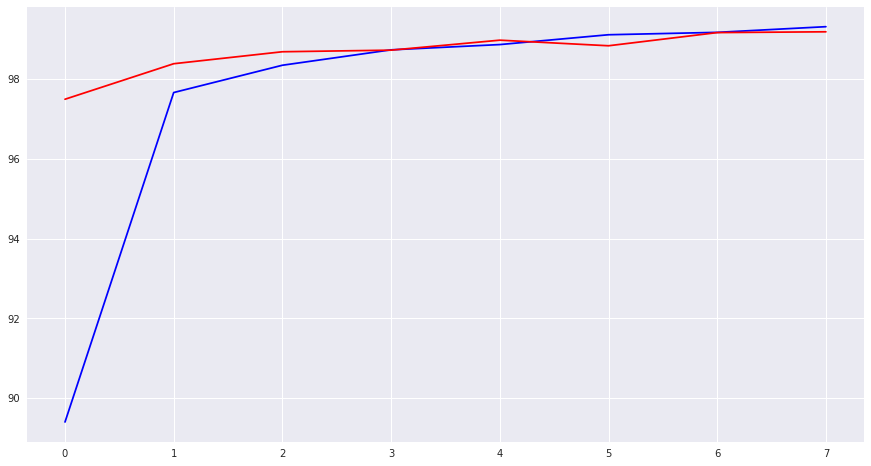

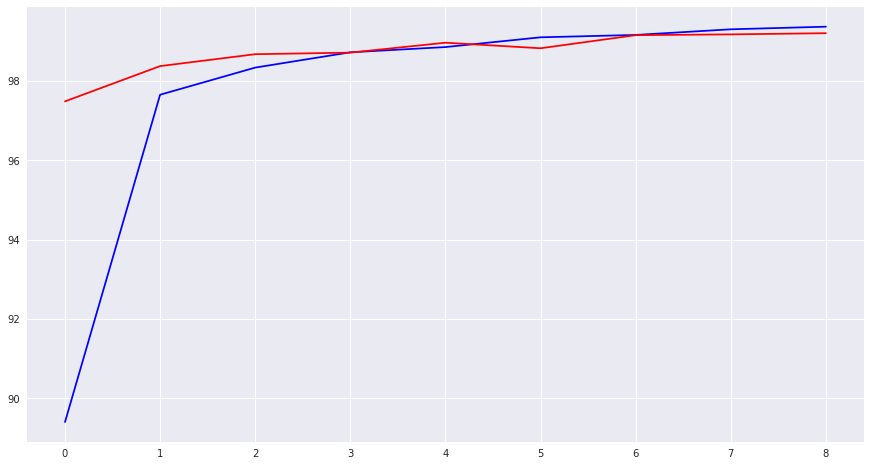

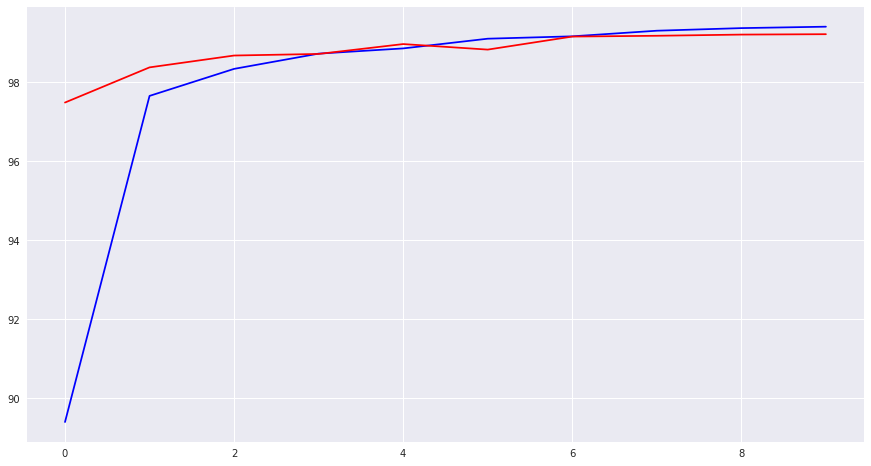

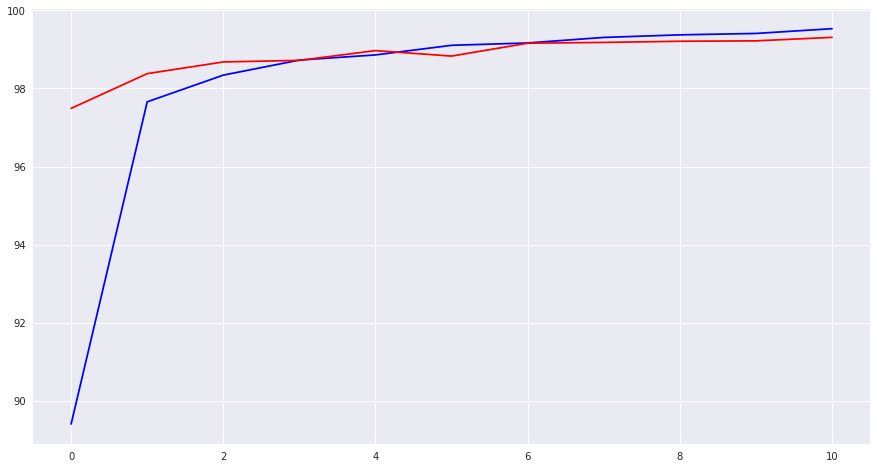

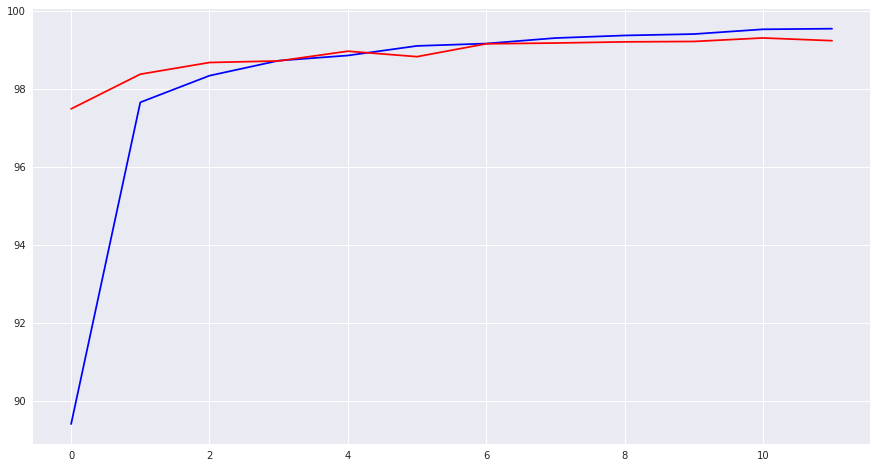

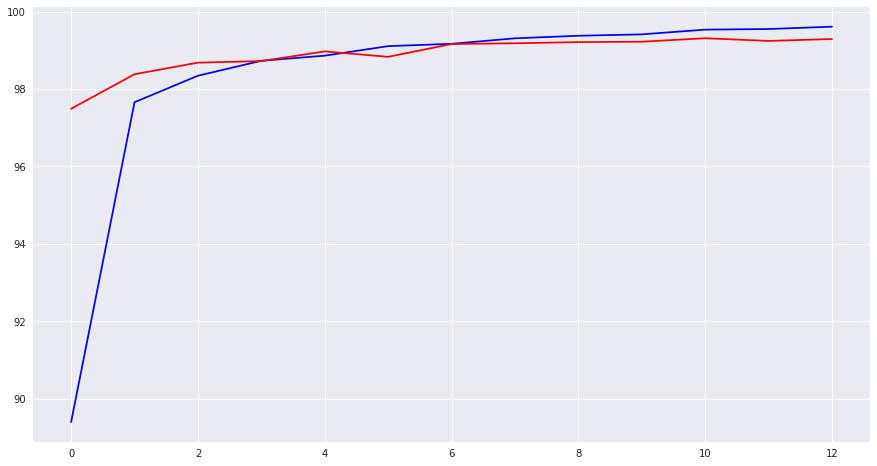

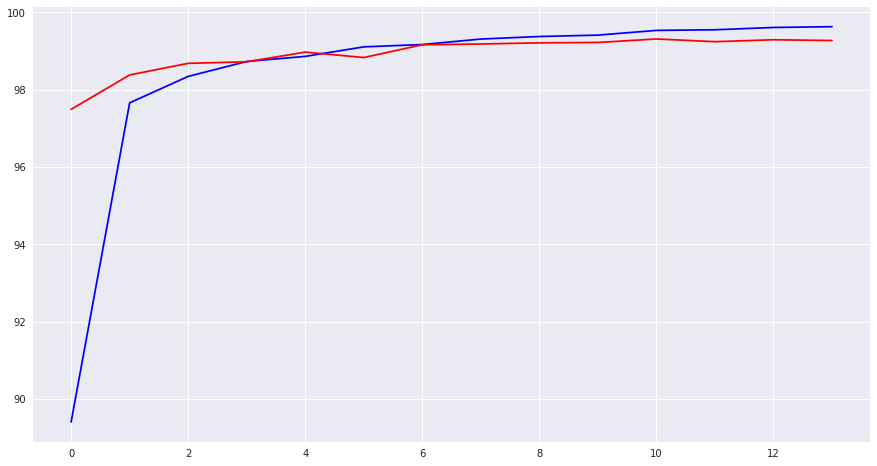

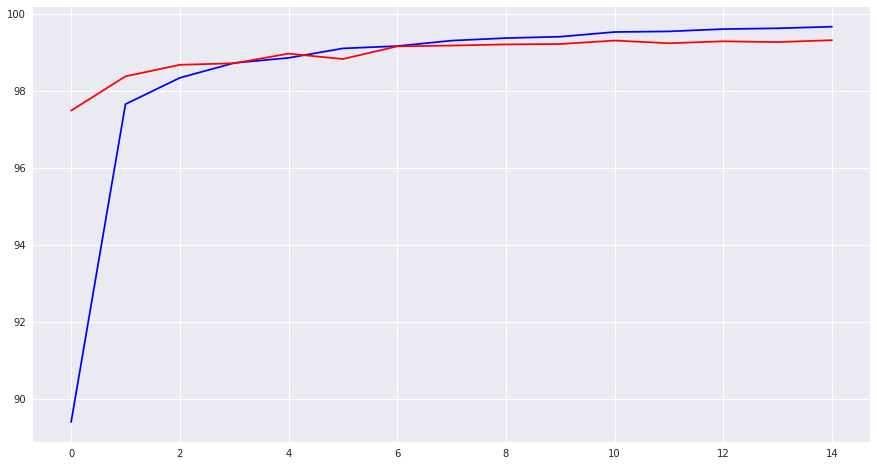

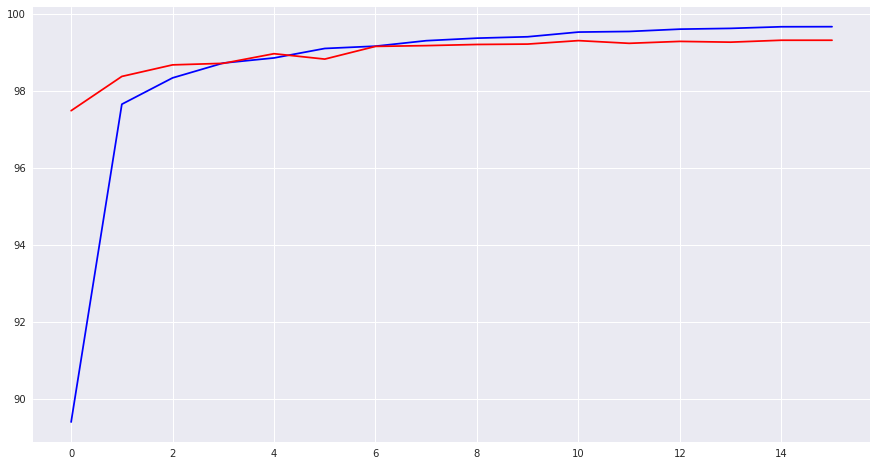

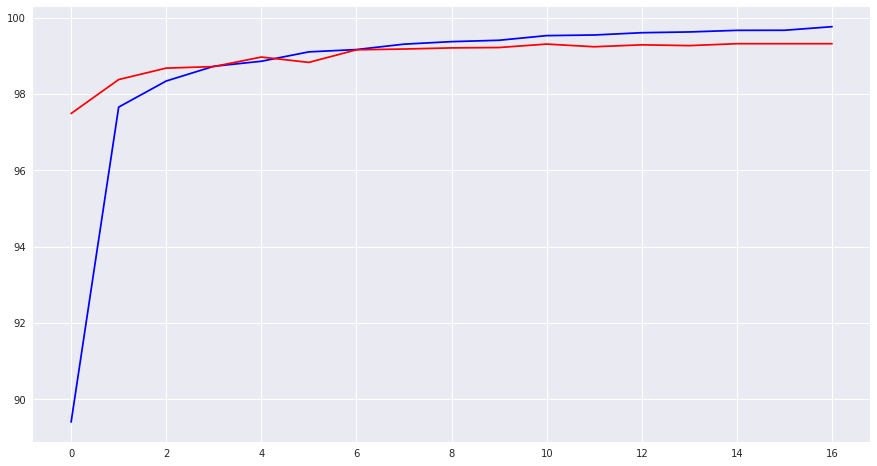

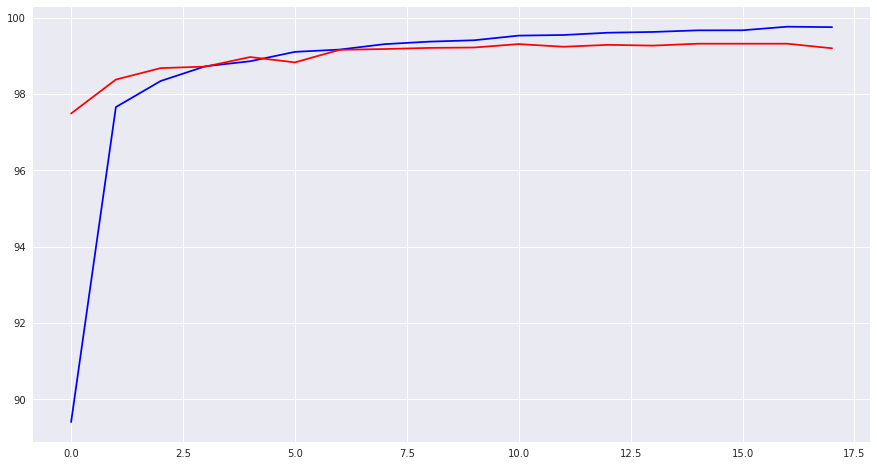

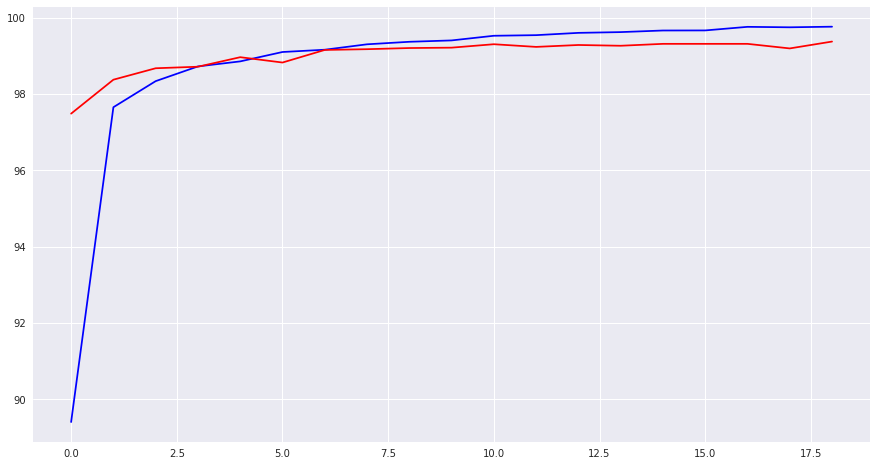

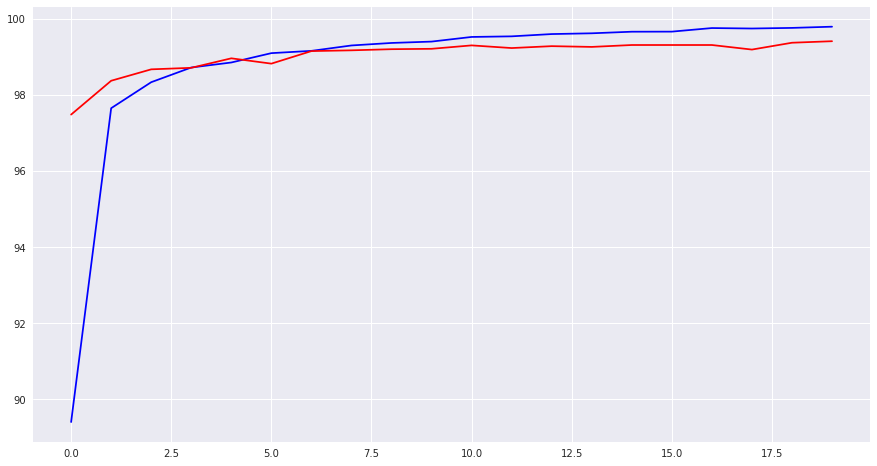

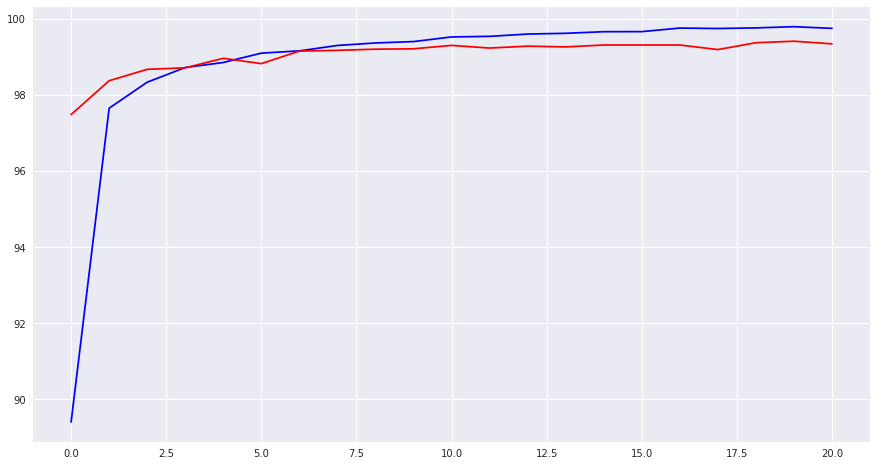

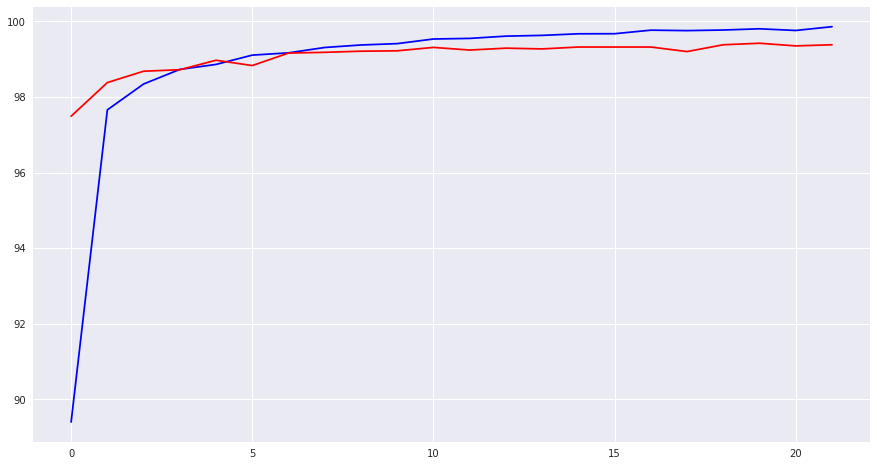

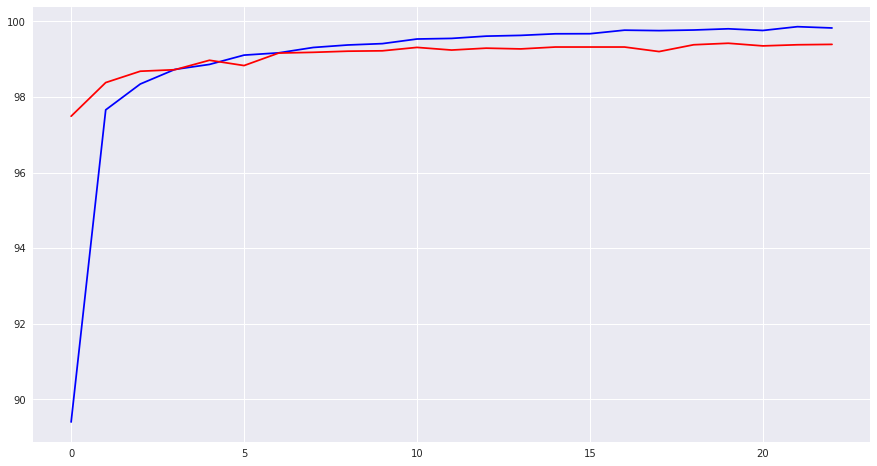

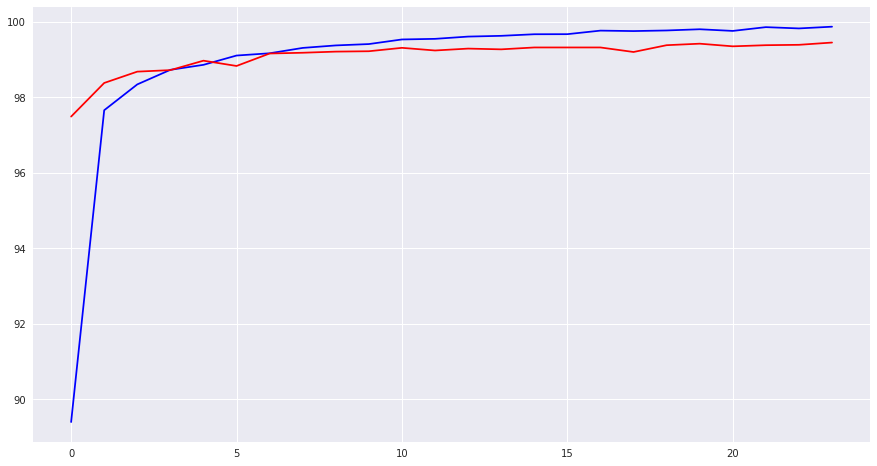

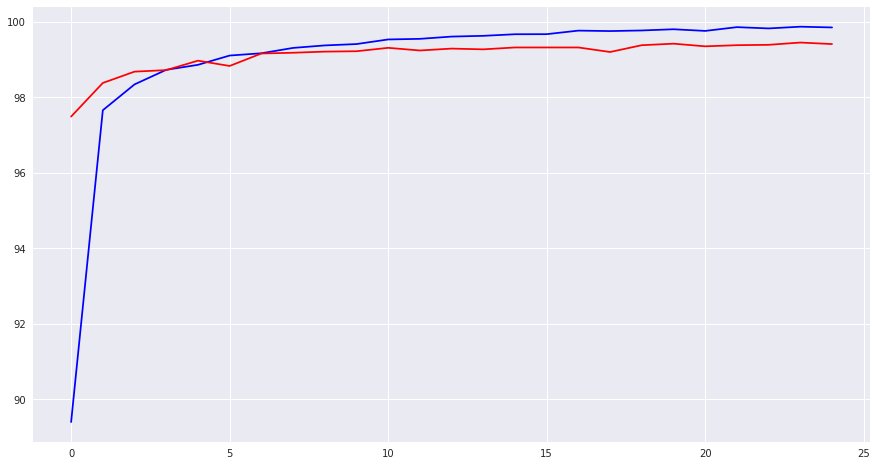

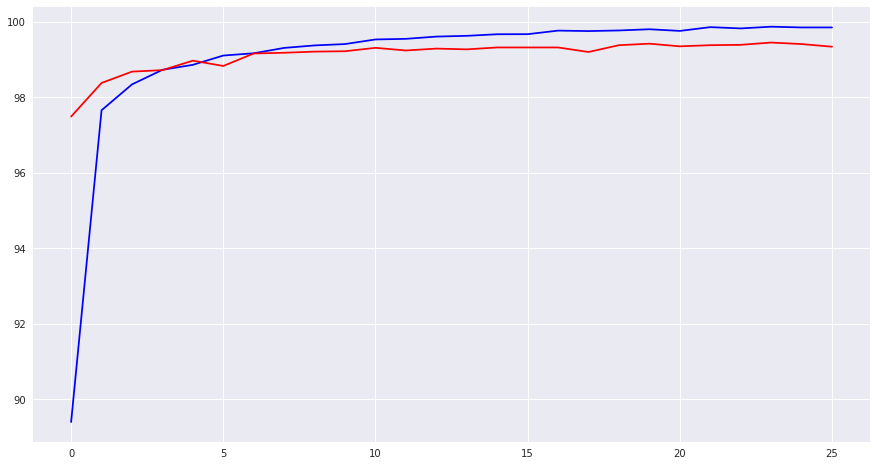

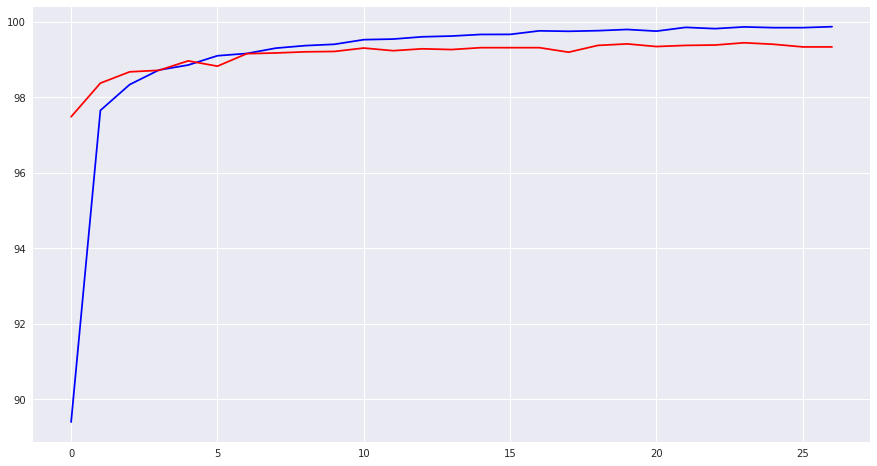

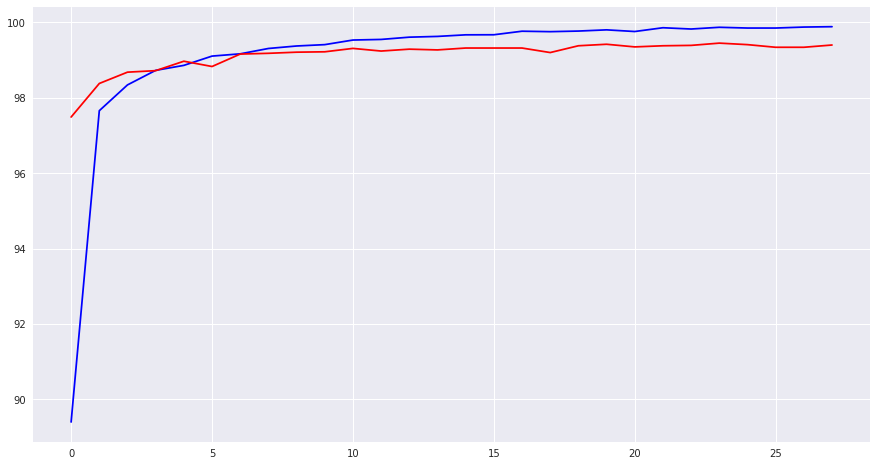

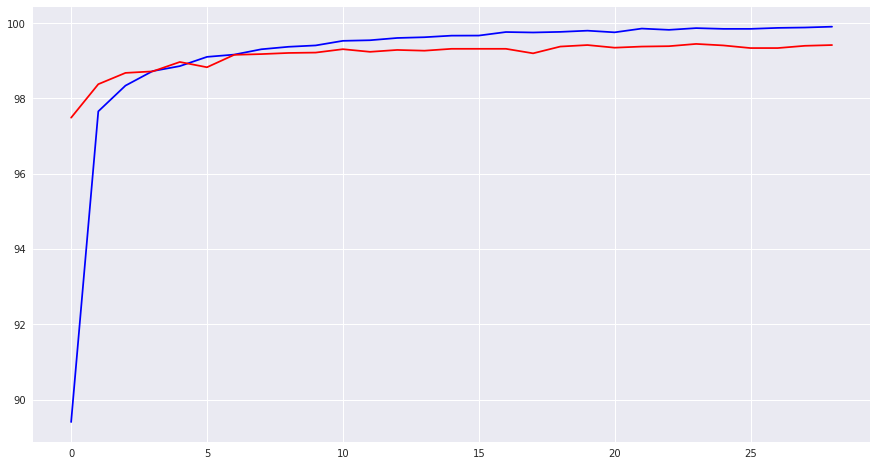

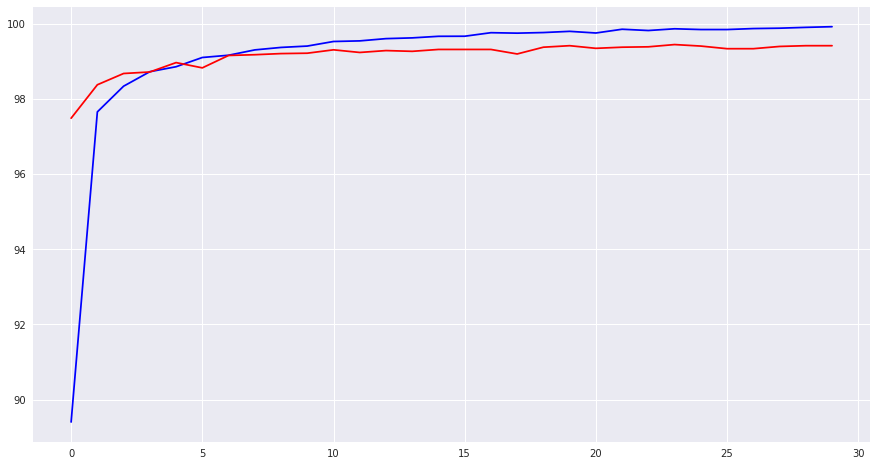

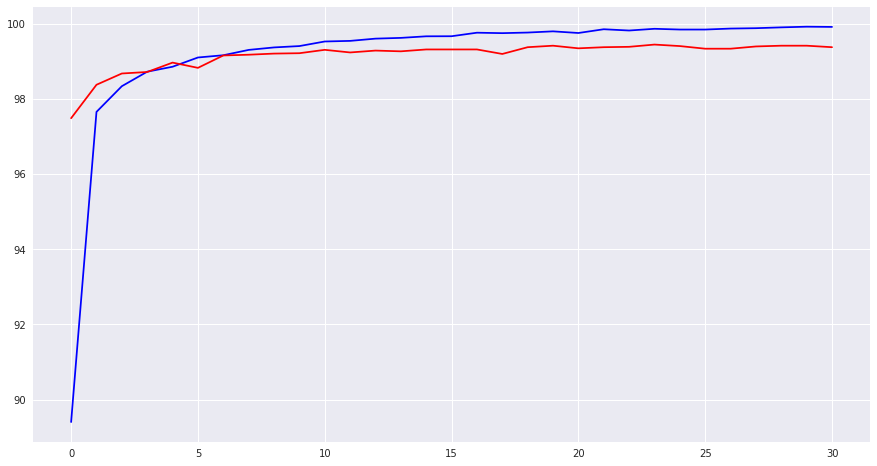

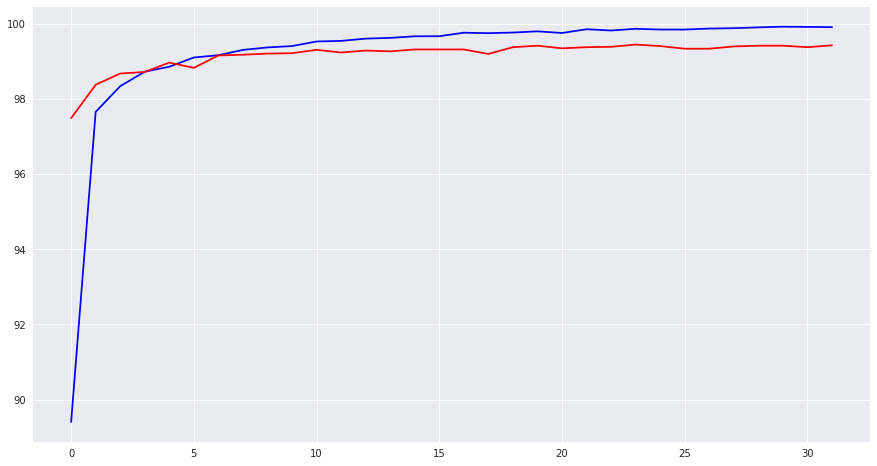

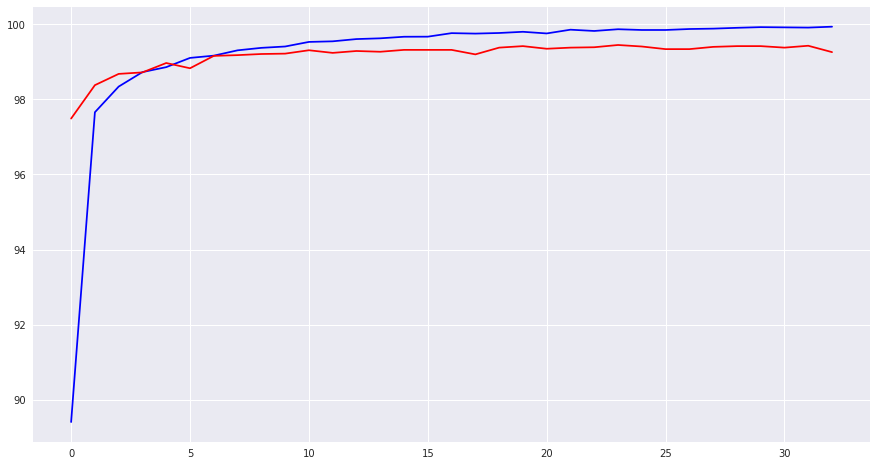

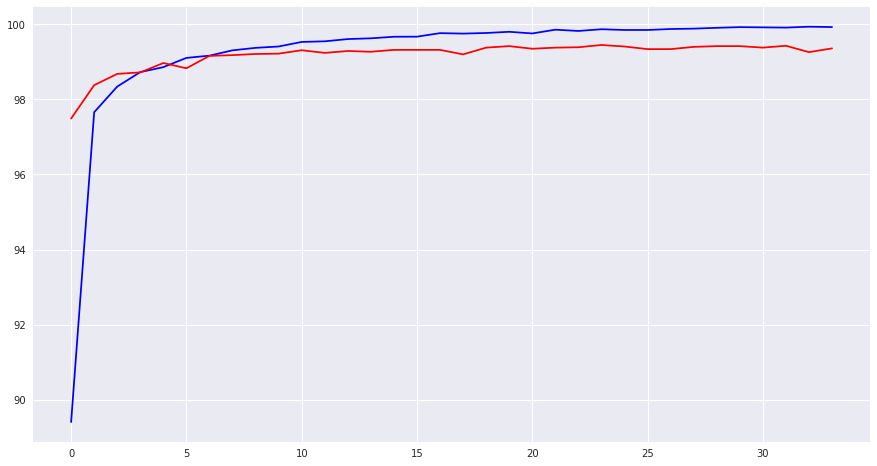

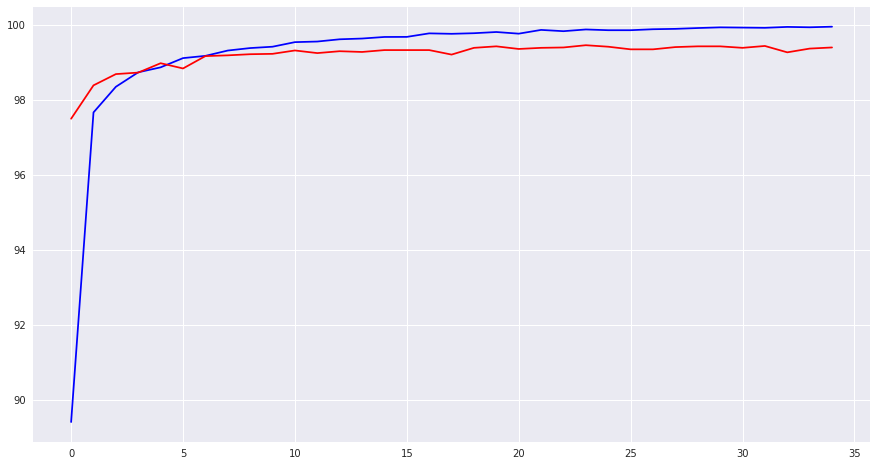

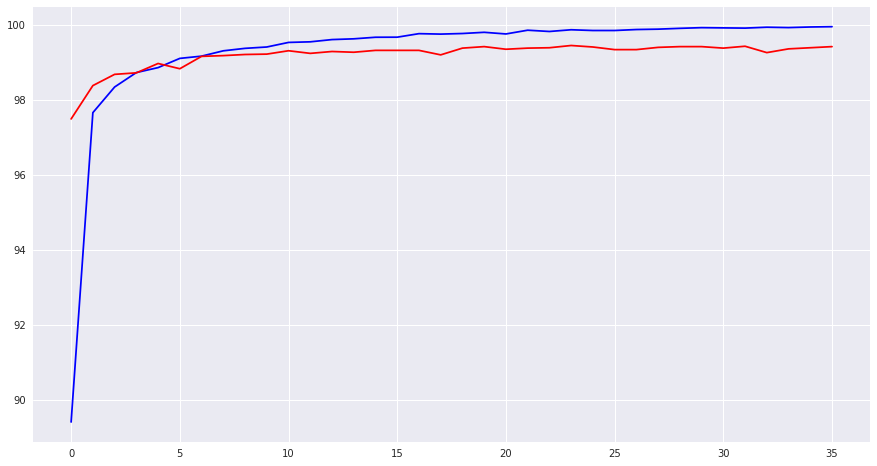

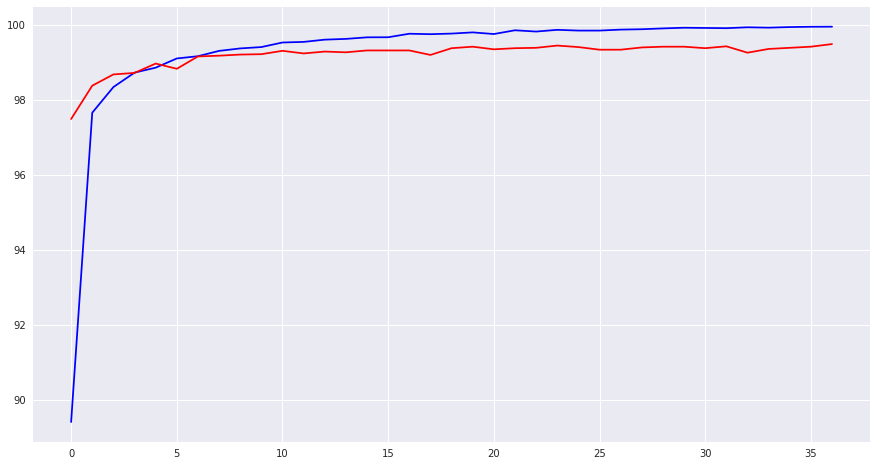

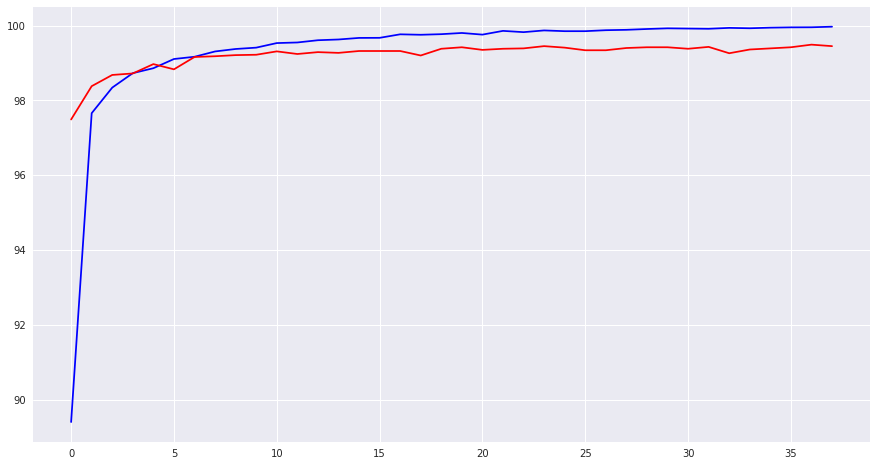

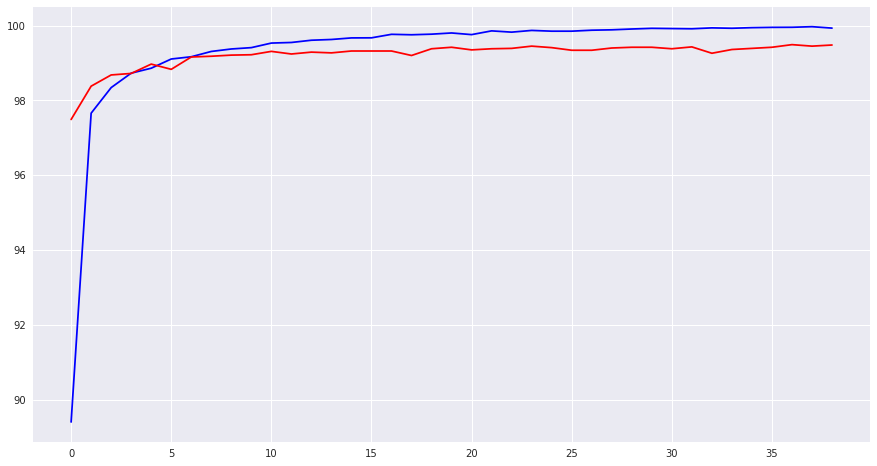

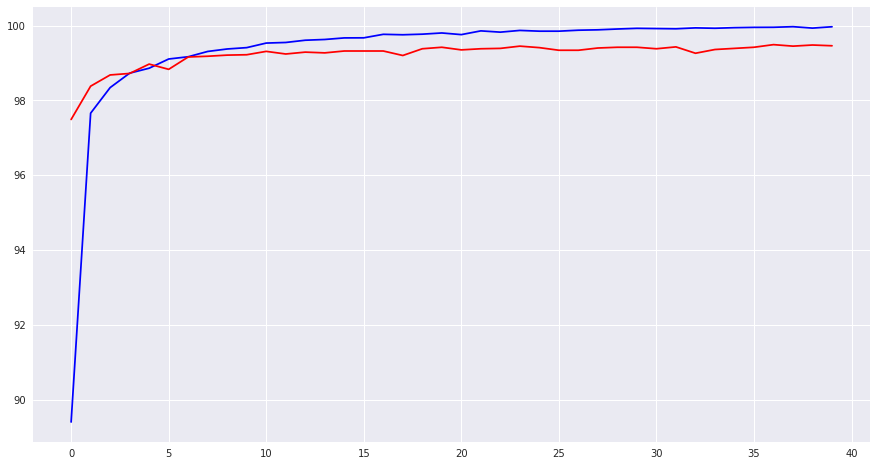

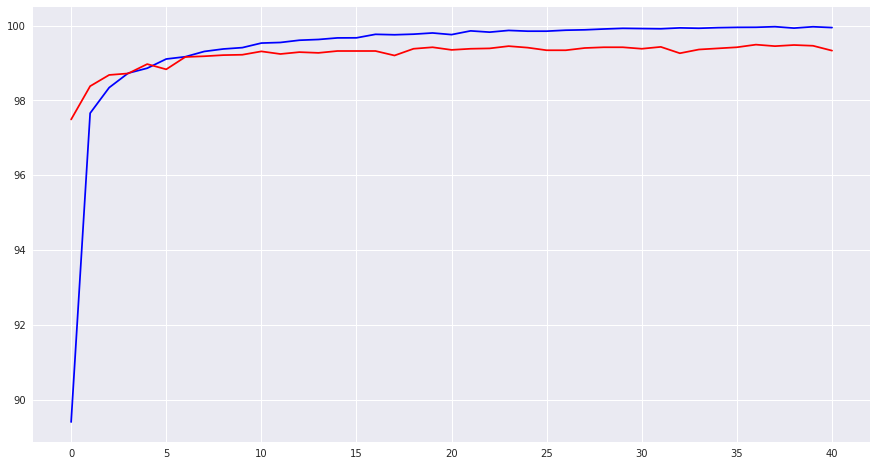

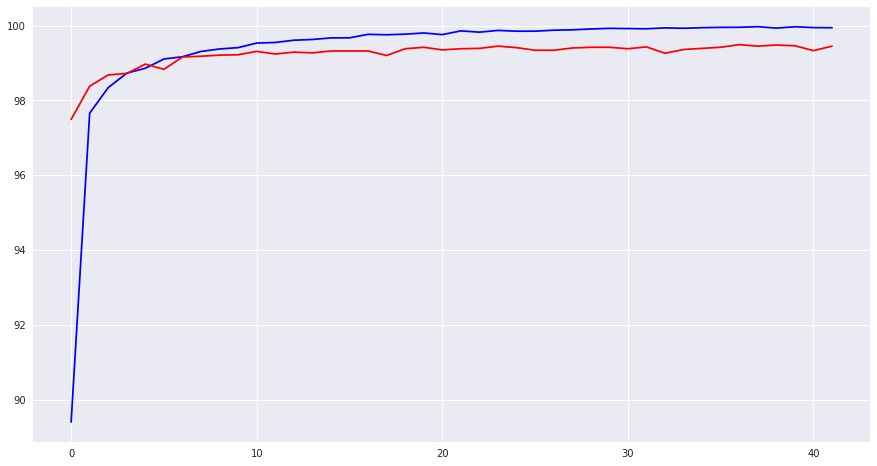

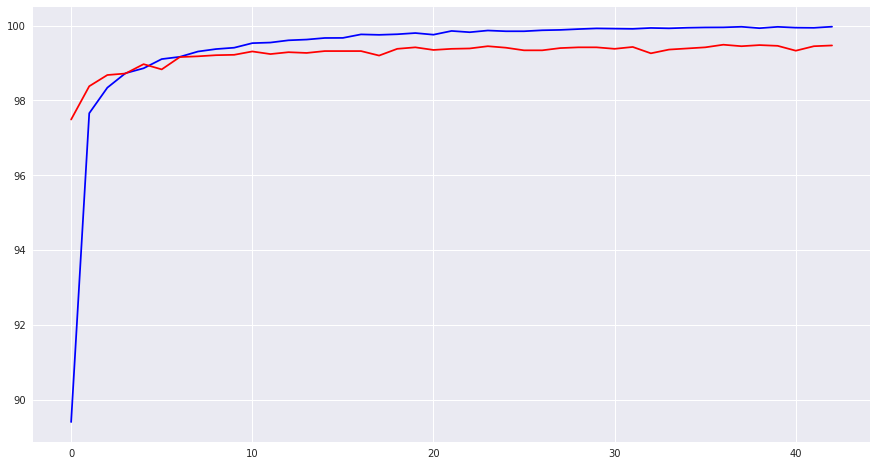

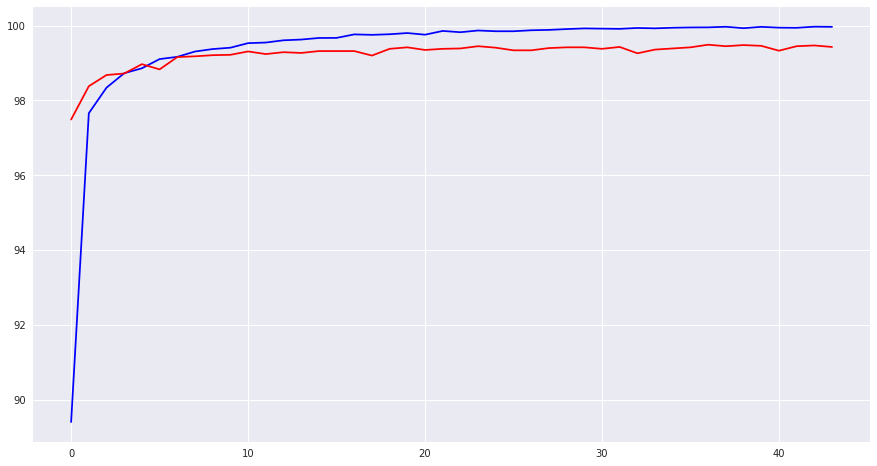

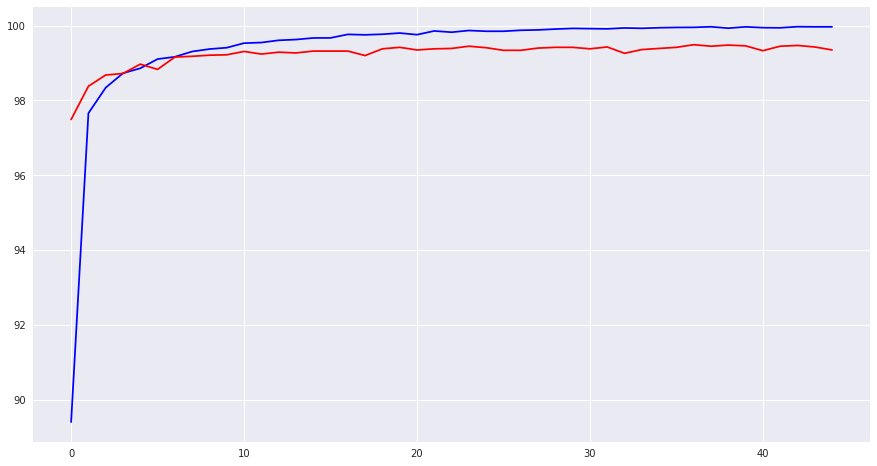

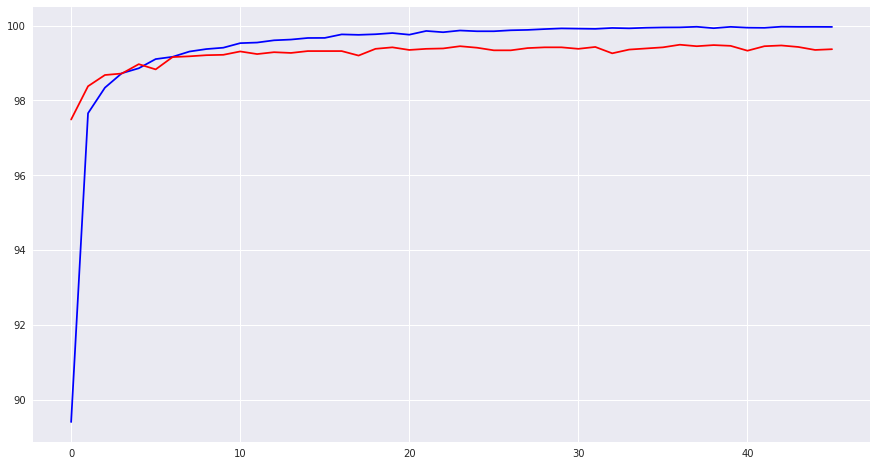

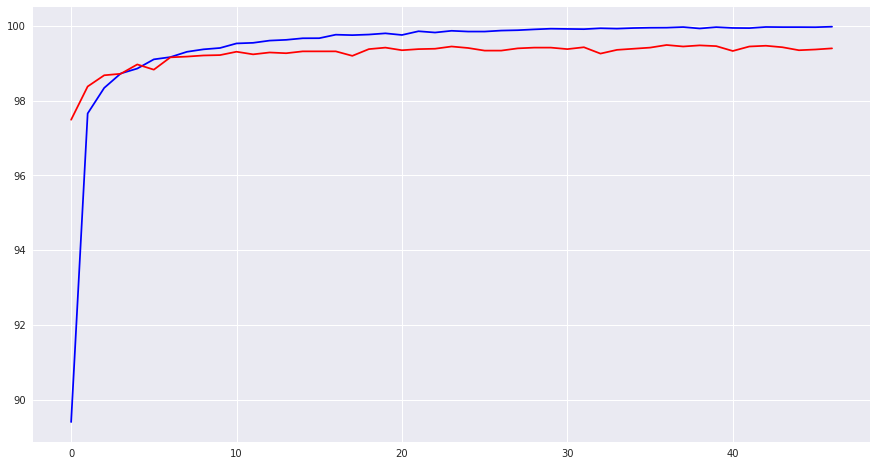

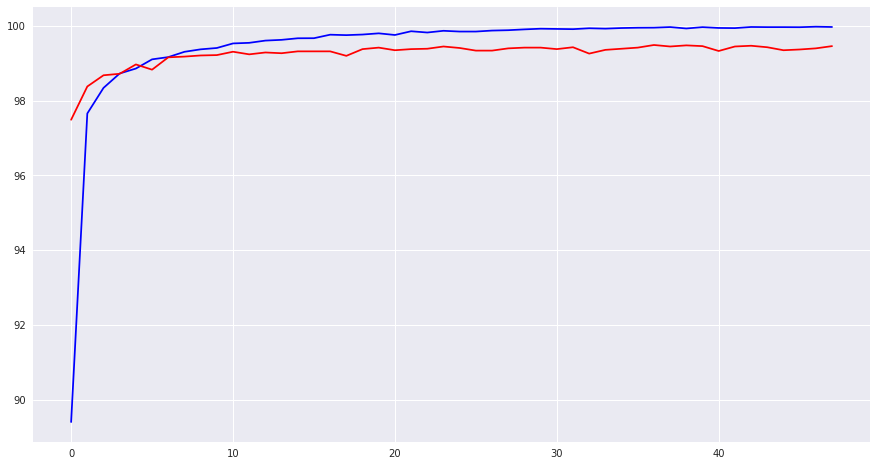

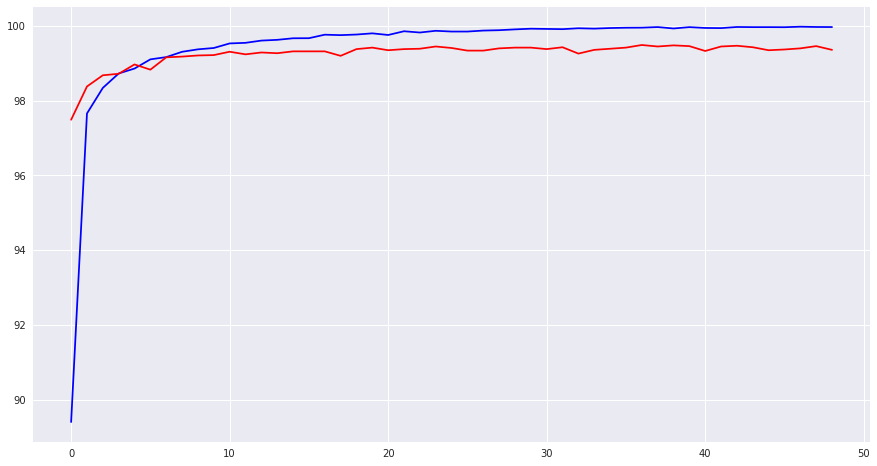

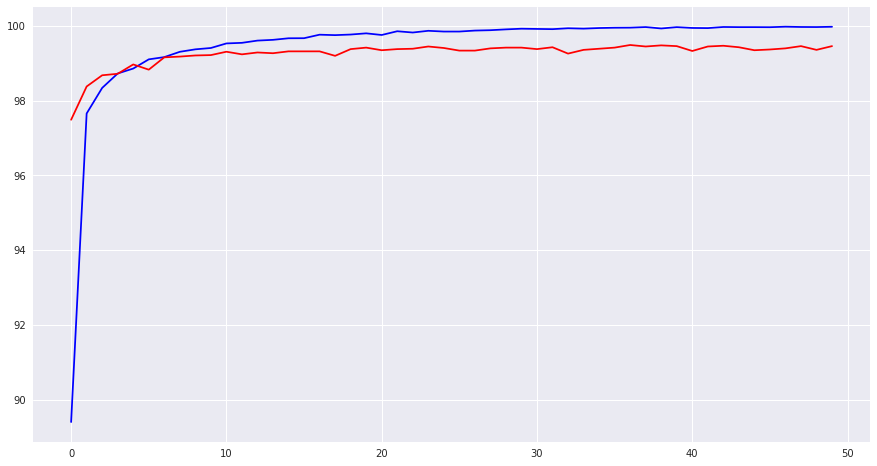

In [37]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    train_loss.append(train_err / train_batches)
    train_accuracy.append(train_acc / train_batches * 100)
    val_accuracy.append(val_acc / val_batches * 100)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(15,8))
    plt.plot(train_accuracy, 'b')
    plt.plot(val_accuracy, 'r')

In [38]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

Final results:
test accuracy:		99.50 %
Achievement unlocked: 80lvl Warlock!


gg wp 

easy :)

Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

Т.к. сеть должна классифицировать изображения цифр, на мой взгляд лучше всего взять CNN, т.к. она сможет выделить некие локальные особенности этих цифр. Я пробовал различные комбинации сверток и макспулингов вначале. Затем брал дропаут в качестве регуляризации, полносвязный слой, а потом выходной слой.

Лучшее качество получается, если делать отдельный макспул после каждой свертки, а не один после нескольких. При этом размер фильтра сначала 5x5, а потом 3x3.

Как показывает качество, одного полносвязного слоя вполне достаточно. Больше слоев лишь будут переобучать сеть. Финальную архитектуру можно посмотреть в ячейке.

Для тренировкий нейросети использовал метод стохастического градиентного спуска.